<a href="https://colab.research.google.com/github/pranshudatascience/Yoga-Pose-Identification/blob/main/Yoga_Pose_Recogination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

# **Uploading Data via Kaggle Api**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datasciencepranshu","key":"f206fef76574e388b3dba86a1861be62"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shrutisaxena/yoga-pose-image-classification-dataset

100% 0.98G/0.98G [00:26<00:00, 54.1MB/s]
100% 0.98G/0.98G [00:26<00:00, 39.2MB/s]


In [5]:
from zipfile import ZipFile
file_name = "yoga-pose-image-classification-dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
IMAGE_SIZE = [224, 224]

In [6]:
#Give dataset path
train_path = '/content/dataset'
#test_path = '/content/validation/validation'

In [7]:
folders = glob('/content/dataset/*')
len(folders)

107

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Designing Our Model**

In [9]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 2s 0us/step


In [10]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=107, activation='softmax')(x)
model = Model(InceptionV3_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

# **Image Augmentation**

In [12]:
# Use the Image Data Generator to import the images from the dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)  # val 20%

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#no flip and zoom for test dataset

In [13]:
# Make sure you provide the same target size as initialied for the image size

training_set = train_datagen.flow_from_directory('/content/dataset',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset = 'training')

Found 4835 images belonging to 107 classes.


In [14]:
test_set = test_datagen.flow_from_directory('/content/dataset',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            subset = 'validation')

Found 1156 images belonging to 107 classes.


# **Training Our Model**

In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
 19/152 [==>...........................] - ETA: 1:10 - loss: 0.4572 - accuracy: 0.8411

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


152/152 [==============================] - 92s 603ms/step - loss: 0.5487 - accuracy: 0.8176 - val_loss: 1.9856 - val_accuracy: 0.5407
Epoch 2/25
152/152 [==============================] - 93s 610ms/step - loss: 0.5926 - accuracy: 0.8093 - val_loss: 2.2235 - val_accuracy: 0.5078
Epoch 3/25
152/152 [==============================] - 92s 606ms/step - loss: 0.6525 - accuracy: 0.7897 - val_loss: 1.9229 - val_accuracy: 0.5407
Epoch 4/25
152/152 [==============================] - 91s 599ms/step - loss: 0.6093 - accuracy: 0.8037 - val_loss: 2.0055 - val_accuracy: 0.5424
Epoch 5/25
152/152 [==============================] - 90s 594ms/step - loss: 0.5519 - accuracy: 0.8151 - val_loss: 1.9933 - val_accuracy: 0.5303
Epoch 6/25
152/152 [==============================] - 89s 584ms/step - loss: 0.5508 - accuracy: 0.8145 - val_loss: 1.9779 - val_accuracy: 0.5433
Epoch 7/25
152/152 [==============================] - 89s 587ms/step - loss: 0.5536 - accuracy: 0.8180 - val_loss: 2.1262 - val_accuracy: 0.5

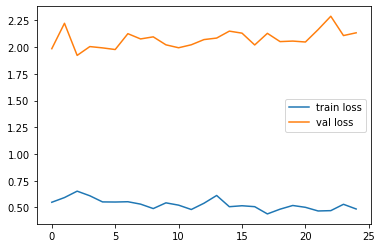

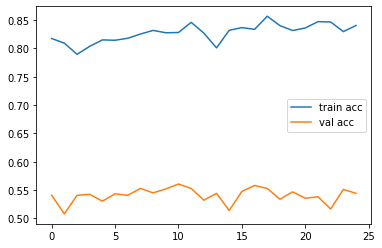

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
from tensorflow.keras.models import load_model

model.save('modelyoga.h5')

# **Making Predictions**

In [21]:
y_pred = model.predict(test_set)

In [22]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([ 89,  56, 103, ...,   6,  85,  17])

# **As there are 107 label claasses , we will take only 10 Labels and make predictions**

In [27]:
def predict_image(img):
    plt.figure(figsize=(40,8))
    print()
    print('---------------------------------Classification of Yoga Pose--------------------------------')
    print()
    print('-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------')
    print()
    x=image.img_to_array(img)
    x=x/255
    plt.imshow(img)
    x=np.expand_dims(x,axis=0)
    #img_data=preprocess_input(x)

    print(np.argmax(model.predict(x)))


---------------------------------Classification of Yoga Pose--------------------------------

-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------

90


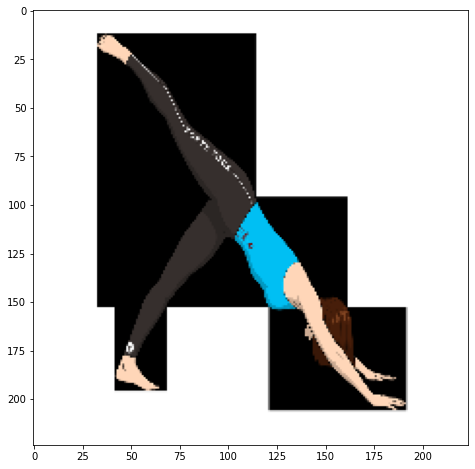

In [28]:
im=image.load_img('/content/dataset/adho mukha svanasana/16. one-leg-downward-facing-dog-yoga-pose.png',target_size=(224,224))
predict_image(im)


---------------------------------Classification of Yoga Pose--------------------------------

-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------

37


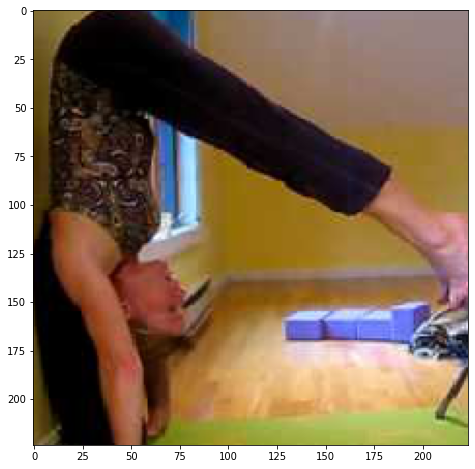

In [29]:
im2=image.load_img('/content/dataset/adho mukha vriksasana/26-0.png',target_size=(224,224))
predict_image(im2)


---------------------------------Classification of Yoga Pose--------------------------------

-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------

3


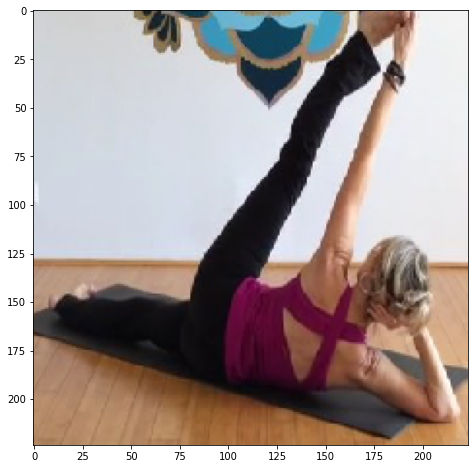

In [30]:
im3=image.load_img('/content/dataset/anantasana/16-0.png',target_size=(224,224))
predict_image(im3)


---------------------------------Classification of Yoga Pose--------------------------------

-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------

102


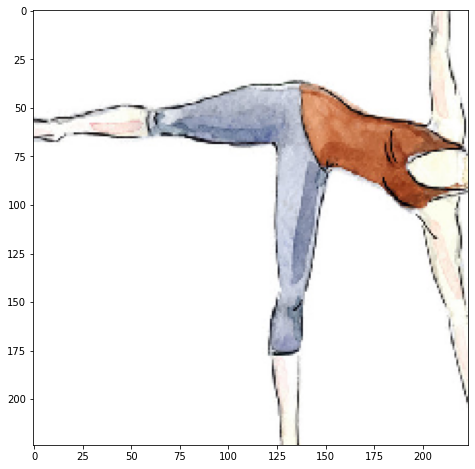

In [31]:
im4=image.load_img('/content/dataset/ardha chandrasana/15-0.png',target_size=(224,224))
predict_image(im4)


---------------------------------Classification of Yoga Pose--------------------------------

-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------

4


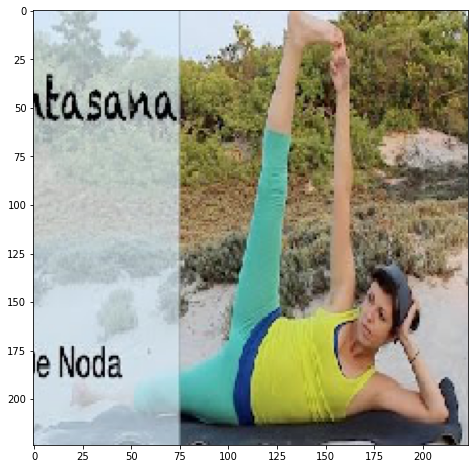

In [32]:
im5=image.load_img('/content/dataset/anantasana/11-0.png',target_size=(224,224))
predict_image(im5)


---------------------------------Classification of Yoga Pose--------------------------------

-----------------------------------THE GiVEN Yoga Pose Is-----------------------------------

93


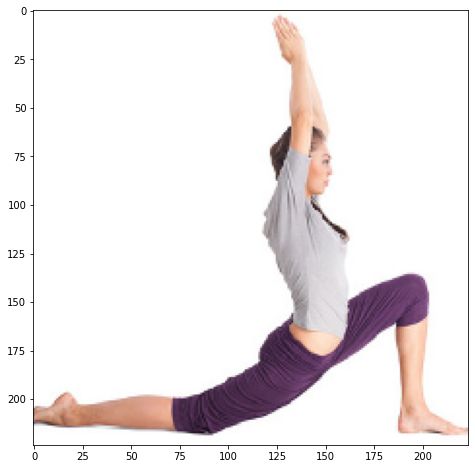

In [33]:
im6=image.load_img('/content/dataset/anjaneyasana/22-0.png',target_size=(224,224))
predict_image(im6)